## In this notebook I have trained the model on the original dataset without making any Images preprocessing or augmentation.
## For this project I have build U-NET model archetictur which is popular for images segmentation.
## For loss function I have used DICE loss function to compute the difference between the model output and the original image label, and I have also used DICE score metric to compute the accuracy.
## I have trained the model twice, one for training the model on each view, and one for training on the full data.¶

## Jaws Segmentation Task
Hello, You're tasked with building a neural network using pytorch which segments upper (Maxilla) and lower(Mandible) jaws in a DICOM file

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal, if you're not familiar with what a DICOM is, you're expected to read online about it

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a zip file, and you mail this zip file to us

In [ ]:
! pip install --user torch torchvision matplotlib numpy progressbar

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=b9fd58ce1437610fcba5f8722af443270ccfa28ff871587a32a5ab6d33e4c718
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [ ]:
! pip install monai

     |████████████████████████████████| 721 kB 4.5 MB/s 


In [ ]:
import numpy as np 
import pandas as pd 
import os

import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm
import monai

In [ ]:
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE = 16
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

In [ ]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

download_data()

downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip


100% (1687658425 of 1687658425) |########| Elapsed Time: 0:02:21 Time:  0:02:21


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip


100% (345779382 of 345779382) |##########| Elapsed Time: 0:00:38 Time:  0:00:38


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip


100% (1688318975 of 1688318975) |########| Elapsed Time: 0:02:21 Time:  0:02:21


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip


100% (347373983 of 347373983) |##########| Elapsed Time: 0:00:33 Time:  0:00:33


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip


100% (1686885165 of 1686885165) |########| Elapsed Time: 0:02:19 Time:  0:02:19


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip


100% (346507429 of 346507429) |##########| Elapsed Time: 0:00:33 Time:  0:00:33


## Explore The Dataset
In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you

In [ ]:
class JawsDataset(torch.utils.data.Dataset):
    def __init__(self, dicom_file_list, transforms):
        self.dicom_file_list = dicom_file_list
        self.transforms = transforms

    def __len__(self):
        return len(self.dicom_file_list)

    def __getitem__(self, idx):
        dicom_path = self.dicom_file_list[idx]
        label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
        dicom_file = gzip.GzipFile(dicom_path, 'rb')
        dicom = np.load(dicom_file)
        label_file = gzip.GzipFile(label_path, 'rb')
        label = np.load(label_file)
        return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
    files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:], transforms),
            JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
    files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:], transforms),
            JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
    files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:], transforms),
            JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
    files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
    files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
    files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, transforms)


In [ ]:
dataset_transforms = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize((128, 128))])

In [ ]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(dataset_transforms)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(dataset_transforms)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(dataset_transforms)
print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')

axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice
coronal training dataset: 7277 slice
sagittal training dataset: 7277 slice


In [ ]:
print(f'axial validatiaon dataset: {len(axial_validatiaon_dataset)} slice')
print(f'coronal validatiaon dataset: {len(coronal_validation_dataset)} slice')
print(f'sagittal validatiaon dataset: {len(sagittal_validation_dataset)} slice')

axial_validatiaon_loader = torch.utils.data.DataLoader(axial_validatiaon_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_validatiaon_loader = torch.utils.data.DataLoader(coronal_validation_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_validatiaon_loader = torch.utils.data.DataLoader(sagittal_validation_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial validatiaon dataset: 561 slice
coronal validatiaon dataset: 809 slice
sagittal validatiaon dataset: 809 slice


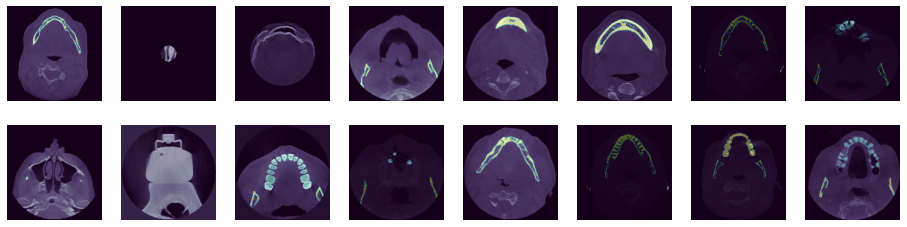

In [ ]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
    plt.subplot(2, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='bone')
    plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

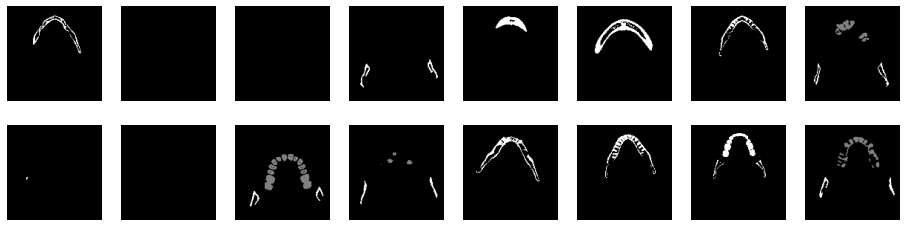

In [ ]:
# axial_data_iter = iter(axial_train_loader)
# images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
    plt.subplot(2, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='bone')
    plt.imshow(labels[index].numpy().squeeze(), cmap='gray')

<Figure size 1152x288 with 0 Axes>

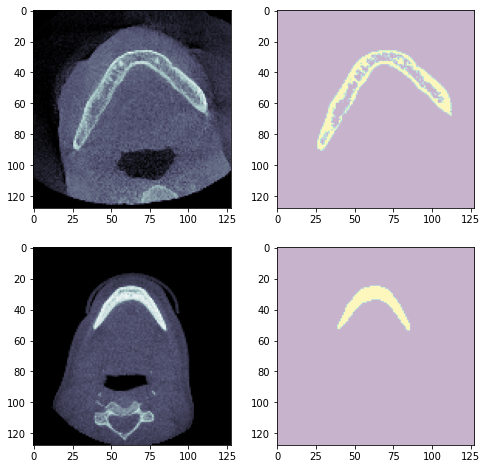

In [ ]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
fig,ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[i,0].imshow(images[i].numpy().squeeze(), cmap='bone')
    ax[i,1].imshow(labels[i].numpy().squeeze(), alpha=0.3)
plt.show()

In [ ]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
print(len(images))
print(images.shape)
print(labels.shape)

16
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


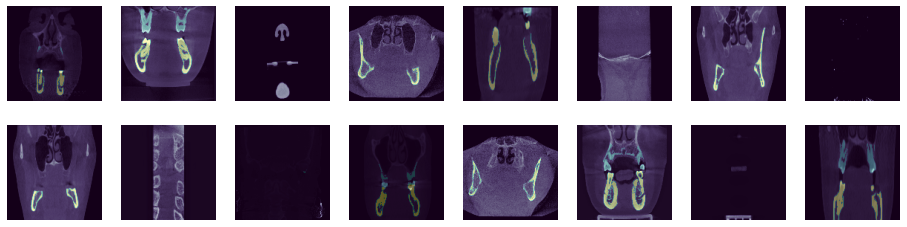

In [ ]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
    plt.subplot(2, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='bone')
    plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

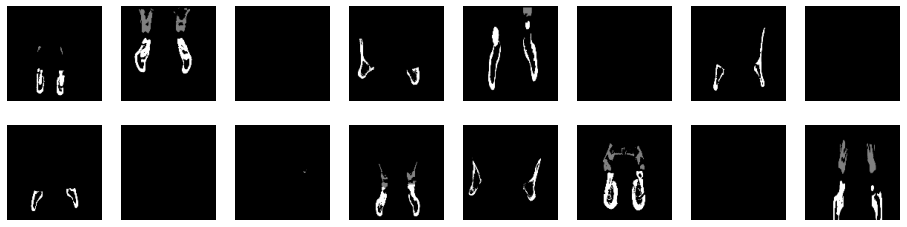

In [ ]:
# coronal_data_iter = iter(coronal_train_loader)
# images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
    plt.subplot(2, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='bone')
    plt.imshow(labels[index].numpy().squeeze(), cmap='gray')

<Figure size 1152x288 with 0 Axes>

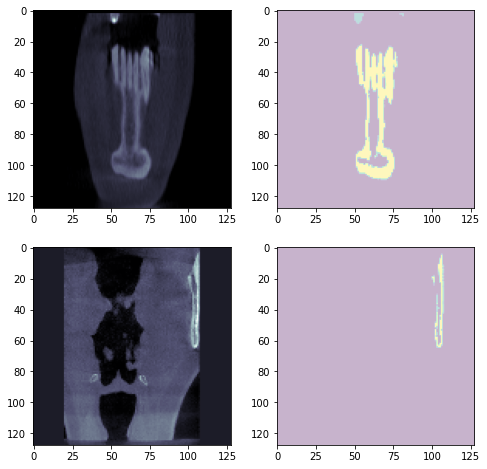

In [ ]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
fig,ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[i,0].imshow(images[i].numpy().squeeze(), cmap='bone')
    ax[i,1].imshow(labels[i].numpy().squeeze(), alpha=0.3)
plt.show()

In [ ]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


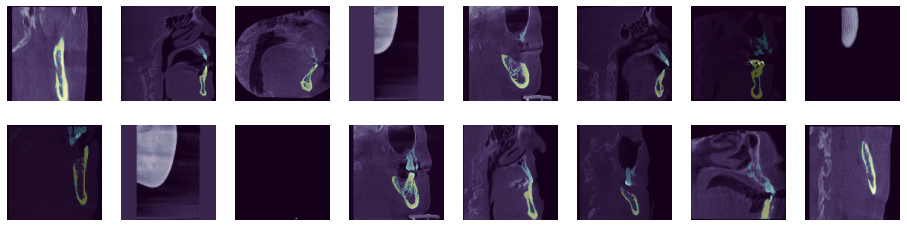

In [ ]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
    plt.subplot(2, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='bone')
    plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

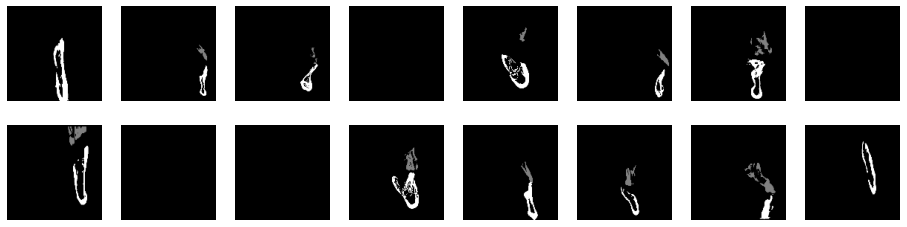

In [ ]:
# sagittal_data_iter = iter(sagittal_train_loader)
# images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
    plt.subplot(2, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='bone')
    plt.imshow(labels[index].numpy().squeeze(), cmap='gray')

<Figure size 1152x288 with 0 Axes>

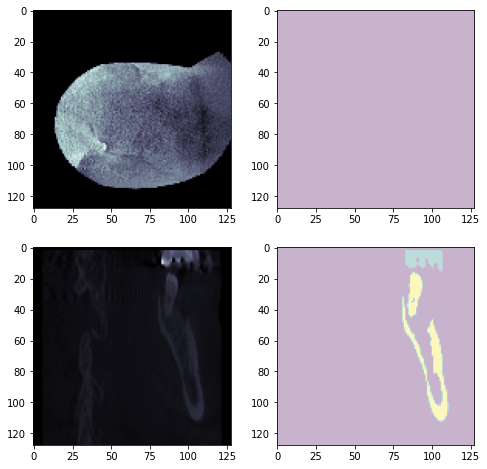

In [ ]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
fig,ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[i,0].imshow(images[i].numpy().squeeze(), cmap='bone')
    ax[i,1].imshow(labels[i].numpy().squeeze(), alpha=0.3)
plt.show()

In [ ]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


## Training
Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(DoubleConv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNET(nn.Module):
    def __init__(
            self, input_channel=3, output_channel=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(input_channel, feature))
            input_channel = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], output_channel, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
def save_checkpoint(state, filename="model_checkpoint.pth.tar"):
    print("Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model):
    print("Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.01):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.flatten()
        targets = targets.flatten()
        
        intersection = np.sum(inputs * targets)                        
        dice = (2.*intersection + smooth)/(np.sum(inputs) + np.sum(targets) + smooth)
        
        return 1 - dice

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            
            # a threshold for pixels predicted object 1 / background 0
            t = .5 
            preds = (preds > t).float()
            
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    
    for batch_idx, (images, labels) in enumerate(loop):
        images = images.to(device=DEVICE)
        labels = labels.to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
LOAD_MODEL = False
loss_values = []
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def train_model_2d(train_loaders, val_loaders):
    model = UNET(input_channel=1, output_channel=1).to(DEVICE)
    train_loader = train_loaders
    val_loader = val_loaders
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = monai.losses.DiceLoss(sigmoid=True)
    scaler = torch.cuda.amp.GradScaler()
    
    
    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        
        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        
        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)
    
    return model

In [ ]:
def predict(data_loader):
    # Tests

    for i in range(5):
        with torch.no_grad():
            for images ,masks in data_loader :
                images = images.to(DEVICE)
                masks  = masks.to(DEVICE)

                mask_pred = axial_model(images)

                img = mask_pred.cuda()
                masks = masks.cuda()
                masks_2 = (masks > 0.5)
            
                loss_fn = monai.losses.DiceLoss(sigmoid=True)
                loss = loss_fn(mask_pred, masks)
                print("loss prediction: ", float(loss))
            
                img = mask_pred.cpu().numpy()
                masks = masks.cpu().numpy()
                masks_2 = (masks > 0.5).astype(int)
            
                fig, axes = plt.subplots(1, 3, figsize=(15, 15))

                axes[0].imshow(masks[0][0])
                axes[0].set_title('Ground Truth Mask')

                axes[1].imshow(img[0][0])
                axes[1].set_title('Probabilistic Mask')
            
                axes[2].imshow(masks_2[0][0])
                axes[2].set_title('Probabilistic Mask threshold')
            
                break

## Train a model for each view

In [32]:
axial_model = train_model_2d(axial_train_loader, axial_validatiaon_loader)

100%|██████████| 36/36 [00:08<00:00,  4.17it/s]


Dice score: 0.15573520958423615


100%|██████████| 36/36 [00:07<00:00,  4.83it/s]


Dice score: 0.26355433464050293


100%|██████████| 36/36 [00:07<00:00,  4.83it/s]


Dice score: 0.337386816740036


100%|██████████| 36/36 [00:07<00:00,  4.75it/s]


Dice score: 0.4417513310909271


100%|██████████| 36/36 [00:07<00:00,  4.72it/s]


Dice score: 0.08376527577638626


100%|██████████| 36/36 [00:07<00:00,  4.70it/s]


Dice score: 0.5916681885719299


100%|██████████| 36/36 [00:07<00:00,  4.71it/s]


Dice score: 0.4415440857410431


100%|██████████| 36/36 [00:07<00:00,  4.58it/s]


Dice score: 0.24094350636005402


100%|██████████| 36/36 [00:07<00:00,  4.79it/s]


Dice score: 0.6734166741371155


100%|██████████| 36/36 [00:07<00:00,  4.67it/s]

Dice score: 0.2156667858362198


In [33]:
coronal_model = train_model_2d(coronal_train_loader, coronal_validatiaon_loader)

100%|██████████| 51/51 [00:08<00:00,  5.82it/s]


Dice score: 0.0907692164182663


100%|██████████| 51/51 [00:08<00:00,  6.33it/s]


Dice score: 0.13163544237613678


100%|██████████| 51/51 [00:07<00:00,  6.38it/s]


Dice score: 0.19547459483146667


100%|██████████| 51/51 [00:08<00:00,  6.35it/s]


Dice score: 0.22009479999542236


100%|██████████| 51/51 [00:08<00:00,  6.34it/s]


Dice score: 0.23466774821281433


100%|██████████| 51/51 [00:07<00:00,  6.38it/s]


Dice score: 0.206174835562706


100%|██████████| 51/51 [00:07<00:00,  6.38it/s]


Dice score: 0.41671910881996155


100%|██████████| 51/51 [00:07<00:00,  6.40it/s]


Dice score: 0.5128422379493713


100%|██████████| 51/51 [00:08<00:00,  6.37it/s]


Dice score: 0.3045879304409027


100%|██████████| 51/51 [00:07<00:00,  6.38it/s]


Dice score: 0.37089383602142334


In [34]:
sagittal_model = train_model_2d(sagittal_train_loader, sagittal_validatiaon_loader)

100%|██████████| 51/51 [00:08<00:00,  5.92it/s]


Dice score: 0.07022685557603836


100%|██████████| 51/51 [00:08<00:00,  6.34it/s]


Dice score: 0.1370801329612732


100%|██████████| 51/51 [00:08<00:00,  6.34it/s]


Dice score: 0.17388559877872467


100%|██████████| 51/51 [00:08<00:00,  6.37it/s]


Dice score: 0.1615006923675537


100%|██████████| 51/51 [00:08<00:00,  6.27it/s]


Dice score: 0.25649967789649963


100%|██████████| 51/51 [00:08<00:00,  6.33it/s]


Dice score: 0.2734130620956421


100%|██████████| 51/51 [00:08<00:00,  6.33it/s]


Dice score: 0.5953147411346436


100%|██████████| 51/51 [00:08<00:00,  6.31it/s]


Dice score: 0.26128947734832764


100%|██████████| 51/51 [00:08<00:00,  6.16it/s]


Dice score: 1.0581876039505005


100%|██████████| 51/51 [00:08<00:00,  6.30it/s]


Dice score: 0.31570857763290405


## Testing
Now you should run your trained model on the test dataset available below and report your results

In [35]:
axial_test_dataset = axial_dataset_test(dataset_transforms)
coronal_test_dataset = coronal_dataset_test(dataset_transforms)
sagittal_test_dataset = sagittal_dataset_test(dataset_transforms)
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial testing dataset: 1450 slice
coronal testing dataset: 2348 slice
sagittal testing dataset: 2448 slice


In [36]:
check_accuracy(axial_test_loader, axial_model, device=DEVICE)

100%|██████████| 316/316 [01:05<00:00,  4.86it/s]


Dice score: 0.40491464734077454


loss prediction:  0.160635843873024
loss prediction:  0.24721172451972961
loss prediction:  0.023841887712478638
loss prediction:  0.08333800733089447
loss prediction:  -0.007427584379911423


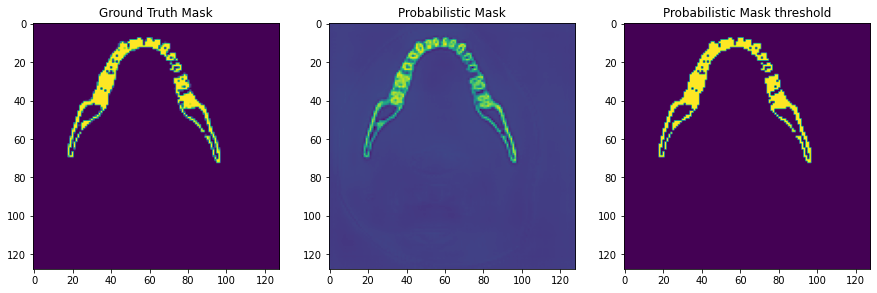

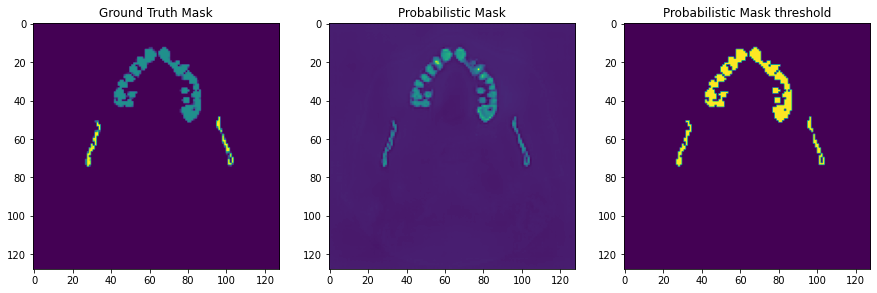

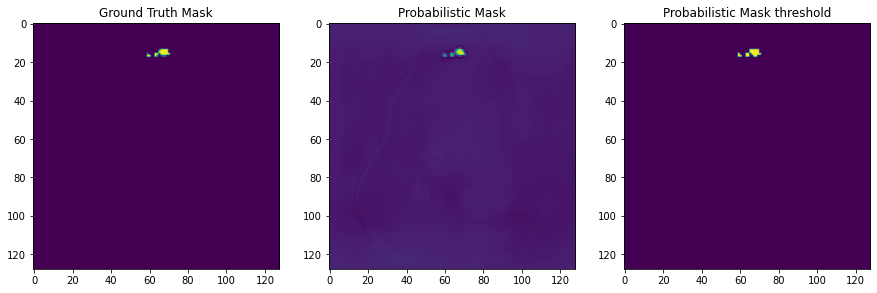

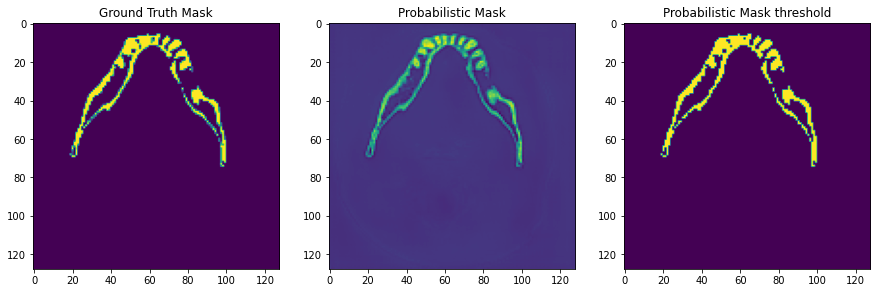

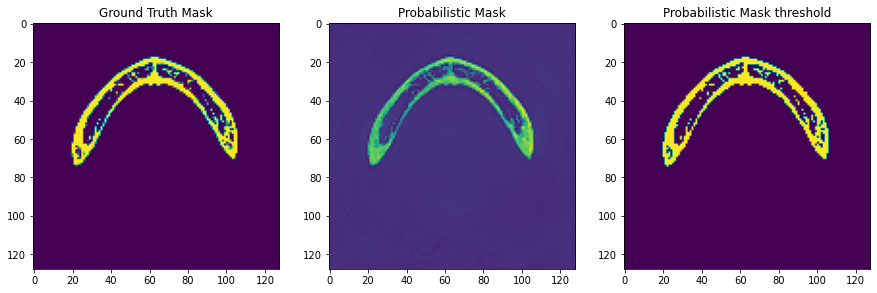

In [37]:
predict(axial_test_loader)

In [38]:
check_accuracy(coronal_test_loader, coronal_model, device=DEVICE)

100%|██████████| 455/455 [01:12<00:00,  6.29it/s]


Dice score: 0.4082881212234497


loss prediction:  0.2754664719104767
loss prediction:  0.22300216555595398
loss prediction:  0.432517409324646
loss prediction:  0.31768539547920227
loss prediction:  0.2745365500450134


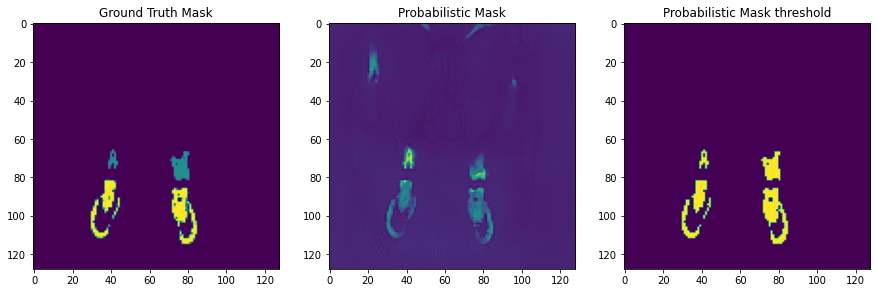

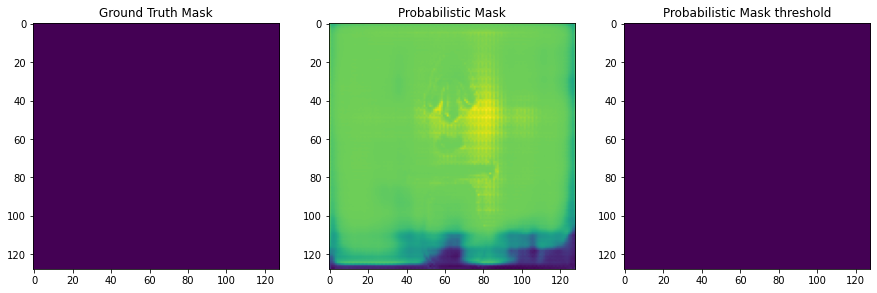

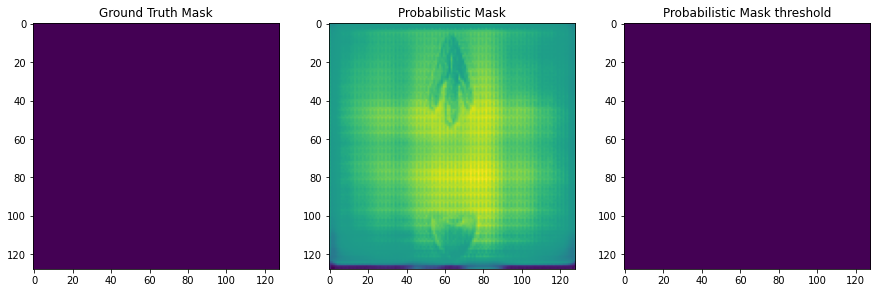

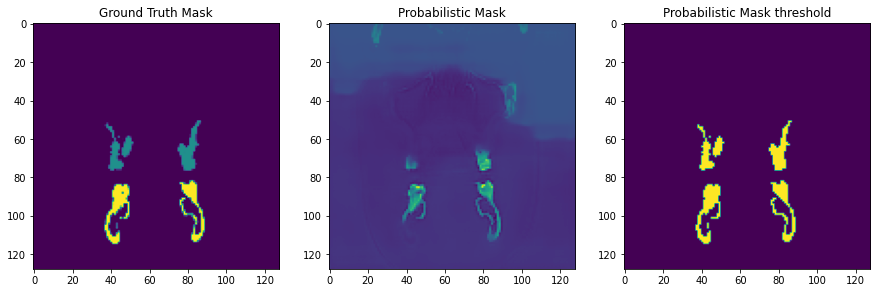

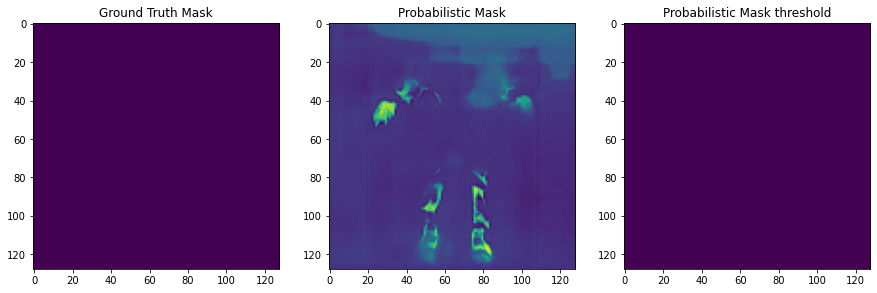

In [39]:
predict(coronal_test_loader)

In [40]:
check_accuracy(sagittal_test_loader, sagittal_model, device=DEVICE)

100%|██████████| 455/455 [01:13<00:00,  6.18it/s]


Dice score: 0.5476982593536377


loss prediction:  0.36434826254844666
loss prediction:  0.38848042488098145
loss prediction:  0.2806357741355896
loss prediction:  0.3249077796936035
loss prediction:  0.5343731641769409


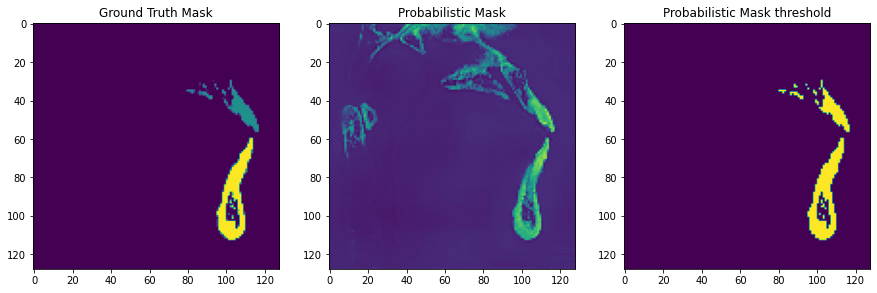

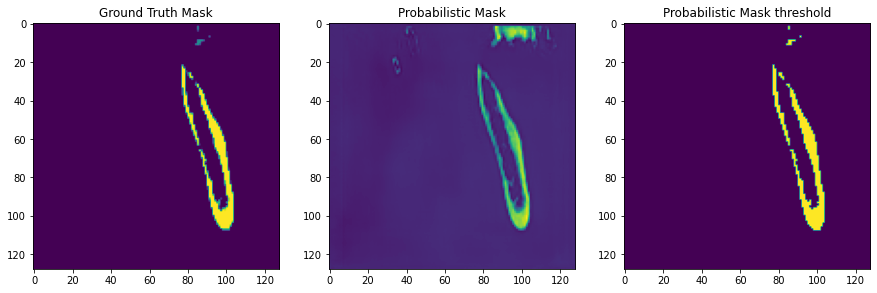

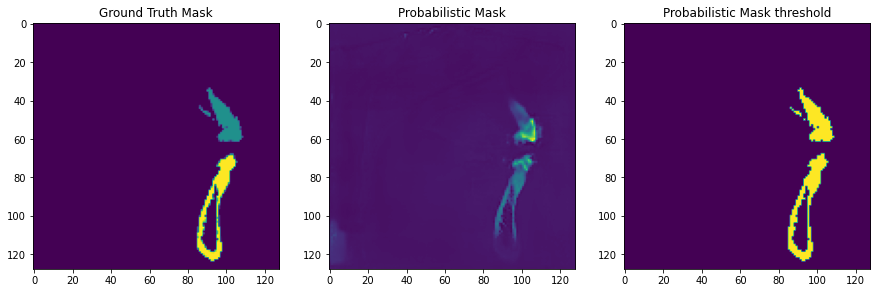

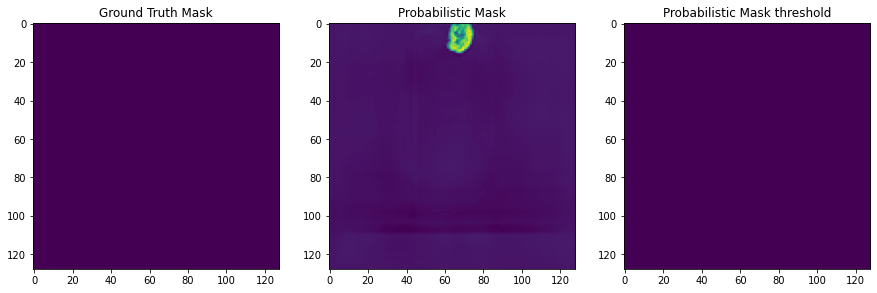

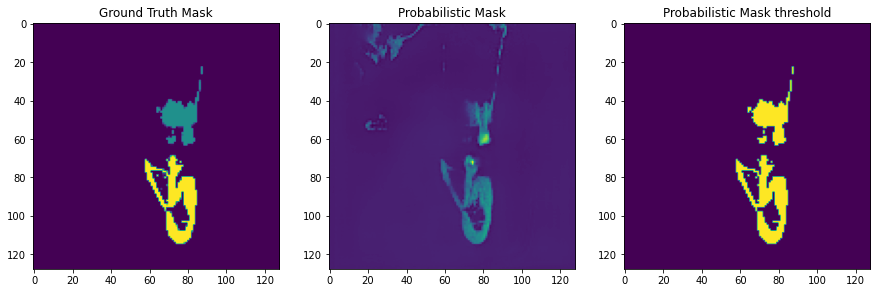

In [41]:
predict(sagittal_test_loader)

## Train one model on the three views

In [42]:
all_train_data = torch.utils.data.ConcatDataset([axial_train_dataset, coronal_train_dataset, sagittal_train_dataset])
all_train_loader = torch.utils.data.DataLoader(all_train_data, shuffle=True, batch_size=BATCH_SIZE)

all_validation_data = torch.utils.data.ConcatDataset([axial_validatiaon_dataset, coronal_validation_dataset, sagittal_validation_dataset])
all_validation_loader = torch.utils.data.DataLoader(all_validation_data, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
model = train_model_2d(all_train_loader, all_validation_loader)

100%|██████████| 137/137 [00:23<00:00,  5.84it/s]


Dice score: 0.4216673672199249


100%|██████████| 137/137 [00:23<00:00,  5.73it/s]


Dice score: 0.44900357723236084


100%|██████████| 137/137 [00:23<00:00,  5.89it/s]


Dice score: 0.48132508993148804


100%|██████████| 137/137 [00:24<00:00,  5.66it/s]


Dice score: 1.0667299032211304


100%|██████████| 137/137 [00:24<00:00,  5.68it/s]


Dice score: 1.1071665287017822


100%|██████████| 137/137 [00:23<00:00,  5.86it/s]


Dice score: 1.0948374271392822


 85%|████████▌ | 1044/1225 [10:17<01:45,  1.71it/s, loss=0.393]

In [2]:
all_test_data = torch.utils.data.ConcatDataset([axial_test_dataset, coronal_test_dataset, sagittal_test_dataset])
all_test_loader = torch.utils.data.DataLoader(all_test_data, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
check_accuracy(all_test_loader, model, device=DEVICE)

In [ ]:
predict(all_test_loader)